<a href="https://colab.research.google.com/github/alek00sandra/Brain-CT-Images/blob/main/Brain_CT_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import imageio as iio

In [ ]:
patients = pd.read_csv('\Users\herma\OneDrive\Pulpit\Projekt TOM\data\hemorrhage_diagnosis.csv')
patients.head()

,PatientNumber,SliceNumber,Intraventricular,Intraparenchymal,Subarachnoid,Epidural,Subdural,No_Hemorrhage,Fracture_Yes_No
0,49,1,0,0,0,0,0,1,0
1,49,2,0,0,0,0,0,1,0
2,49,3,0,0,0,0,0,1,0
3,49,4,0,0,0,0,0,1,0
4,49,5,0,0,0,0,0,1,0


In [ ]:
patients.shape

(2501, 9)

In [ ]:
import os
import cv2

def load_images(folder_path):
    
    if not os.path.exists(folder_path): #Sprawdzenie, czy podany folder istnieje
        print("Podany folder nie istnieje.")
        return []

    image_files = [file for file in os.listdir(folder_path) if file.endswith(".jpg")] #Pobranie listy plików z rozszerzeniem .jpg w danym folderze

    images = [] #pusta lista do przechowania wczytanych obrazów

    for file in image_files: # pętla do wczytania obrazów z listy plików
        file_path = os.path.join(folder_path, file) #tworzenie ścieżki
        image = cv2.imread(file_path) #wczytanie obrazu
        images.append(image) #dodanie wczytanego obrazu do listy

    return images


In [ ]:
import matplotlib.pyplot as plt

def display_images(images):
    grid_size = (16, 16)
    fig = plt.figure(figsize=(20, 20))
    #wyświetlanie obrazów
    for i in range(min(len(images), grid_size[0] * grid_size[1])):
        ax = fig.add_subplot(grid_size[0], grid_size[1], i+1)
        ax.imshow(images[i])
        ax.axis('off')

    plt.show()

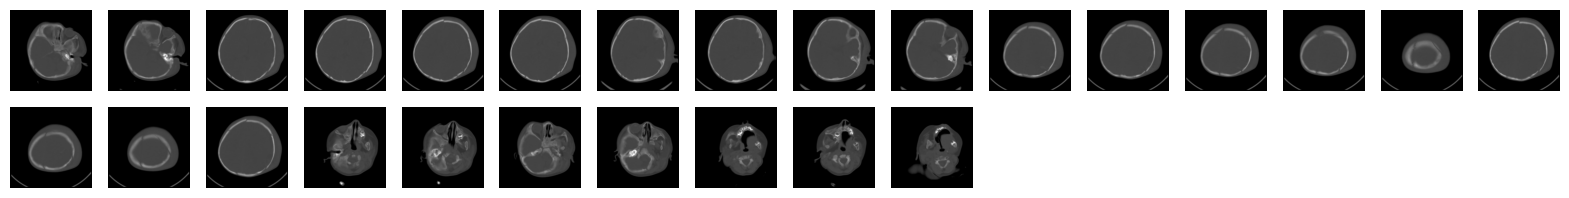

In [ ]:
images_bone = load_images("\Users\herma\OneDrive\Pulpit\Projekt TOM\data\Patients_CT\050\bone")
display_images(images_bone)

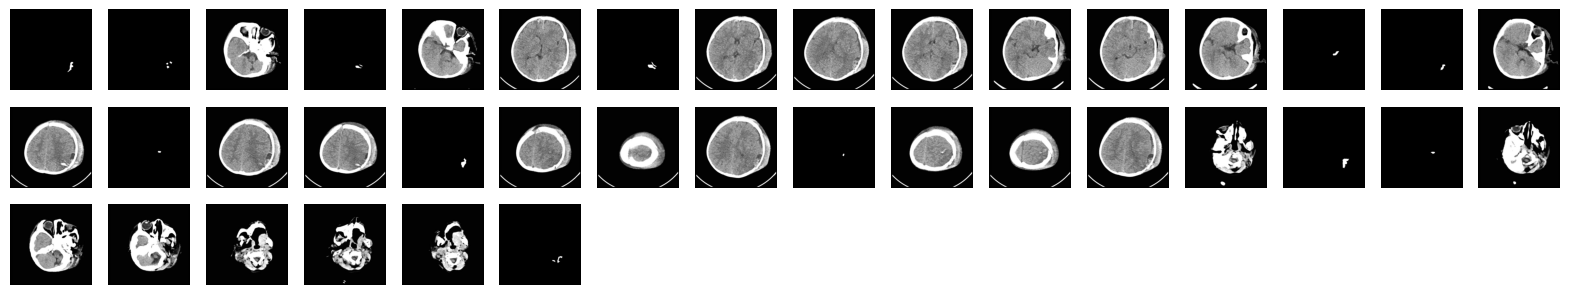

In [ ]:
images_brain = load_images("\Users\herma\OneDrive\Pulpit\Projekt TOM\data\Patients_CT\050\brain")
display_images(images_brain)

In [ ]:
import os
import numpy as np
import torch as tc
import torchvision as tv
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
import pandas as pd
import os

def get_data(folder, window):
    df = pd.read_csv('\Users\herma\OneDrive\Pulpit\Projekt TOM\data\hemorrhage_diagnosis.csv')
    image_paths = []
    classes = []

    for patient in os.listdir(folder):
        if patient == '.DS_Store':
            continue
        
        patient_path = os.path.join(folder, patient, window)

        for photo in os.listdir(patient_path):
            if photo == '.DS_Store' or "Seg" in photo:
                continue
                
            slice_num = int(photo[:-4])

            P = df.loc[(df["PatientNumber"] == int(patient)) & (df["SliceNumber"] == slice_num)]
            image_paths.append(os.path.join(patient_path, photo))
            classes.append(P["No_Hemorrhage"].iloc[0].astype(float))

    return image_paths, classes

FOLDER = "\Users\herma\OneDrive\Pulpit\Projekt TOM\data\Patients_CT"
WINDOW = "brain"

paths, classes = get_data(FOLDER, WINDOW)

In [ ]:
import os
import pandas as pd
import SimpleITK as sitk
from torchvision.io import read_image
import torchvision.transforms as transforms

In [ ]:
class Dataset:
    
    def __init__(self, image_paths, classes):
  
        self.image_paths = image_paths
        self.classes = classes
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        
        img = sitk.GetArrayFromImage(sitk.ReadImage(self.image_paths[idx]))
        img = Image.fromarray(img)
        img = tv.transforms.functional.resize(img, (120,120))
        img = tv.transforms.functional.to_grayscale(img)
        img = tv.transforms.functional.to_tensor(img)
        cls = self.classes[idx]
        
        return img , cls

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV

param_grid={'C':[0.1,1,10,100],'gamma':[0.0001,0.001,0.1,1],'kernel':['rbf','poly']} #zdefiniowanie siatki parametrów do przeszukania
svc=svm.SVC(probability=True) #inicjalizacja klasyfikatora SVM z włączoną estymacją prawdopodobieństwa
model=GridSearchCV(svc,param_grid) #inicjalizacja modelu GridSearchCV, który przeszukuje siatkę parametrów w celu znalezienia najlepszego modelu

In [ ]:
import cv2
#preprocessing
def load_and_process_image(image_path):
    image = cv2.imread(image_path)
    #operacje preprocessingu
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    resized_image = cv2.resize(gray_image, (120, 120))
    normalized_image = resized_image / 255.0
    return normalized_image

In [ ]:
X_train_paths, X_test_paths, y_train_classes, y_test_classes = train_test_split(paths,classes,test_size=0.3,random_state=101) #podział na zbór testowy i treningowy

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

In [ ]:
#przekształcenie obrazów na tensory
transform = transforms.Compose([transforms.ToTensor()])

trainset = Dataset(X_train_paths, y_train_classes)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=32, shuffle=True)

testset = Dataset(X_test_paths, y_test_classes)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=32, shuffle=True)

#przekształcenie danych testowych i treningowych na macierze cech
X_train_features = []

for image_path in X_train_paths:
    image = load_and_process_image(image_path)
    X_train_features.append(image)

X_train_features = np.array(X_train_features)

X_test_features = []
for path in X_test_paths:
    img, _ = testset.__getitem__(X_test_paths.index(path))
    X_test_features.append(img.flatten().numpy())

X_test_features = np.array(X_test_features)

In [ ]:
X_train_features = np.array(X_train_features)
X_test_features = np.array(X_test_features)
y_train_classes = np.array(y_train_classes)
y_test_classes = np.array(y_test_classes)

from PIL import Image

#pętla do dostosowania rozmiaru obrazów w danych treningowych
resized_X_train_features = []
for image in X_train_features:
    resized_image = Image.fromarray(image).resize((200, 200))
    resized_X_train_features.append(np.array(resized_image.copy()))

#pętla do dostosowania rozmiaru obrazów w danych testowych
resized_X_test_features = []
for image in X_test_features:
    resized_image = Image.fromarray(image).resize((200, 200))
    resized_X_test_features.append(np.array(resized_image.copy()))

# Przekształcenie do numpy array
X_train_features = np.array(resized_X_train_features)
X_test_features = np.array(resized_X_test_features)



In [ ]:
from sklearn.tree import DecisionTreeClassifier

X_train_flattened = X_train_features.reshape(X_train_features.shape[0], -1)
X_test_flattened = X_test_features.reshape(X_test_features.shape[0], -1)

# Tworzenie instancji klasyfikatora drzewa decyzyjnego
dt_classifier = DecisionTreeClassifier()

# Trenowanie modelu na danych treningowych
dt_classifier.fit(X_train_flattened, y_train_classes)


DecisionTreeClassifier()

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

In [ ]:
# Definicja modelu
model = Sequential()

model.add(Conv2D(32,(3,3),activation = 'relu',input_shape=(200,200,1)))
model.add(Conv2D(32,(3,3),activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.2))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.2))

model.add(Conv2D(128,(3,3),activation='relu'))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.2))


model.add(Conv2D(256,(3,3),activation='relu'))
model.add(Conv2D(256,(3,3),activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.2))
model.add(Flatten())

model.add(Dense(512,activation = 'relu'))
model.add(Dense(512,activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))

model.summary()

model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 198, 198, 32)      320       
                                                                 
 conv2d_41 (Conv2D)          (None, 196, 196, 32)      9248      
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 98, 98, 32)       0         
 g2D)                                                            
                                                                 
 dropout_25 (Dropout)        (None, 98, 98, 32)        0         
                                                                 
 conv2d_42 (Conv2D)          (None, 96, 96, 64)        18496     
                                                                 
 conv2d_43 (Conv2D)          (None, 94, 94, 64)        36928     
                                                      

In [ ]:
# Trenowanie modelu
history = model.fit(X_train_features, y_train_classes,epochs=10,validation_split=0.15,batch_size=64)

Epoch 1/10
16/24 [===================>..........] - ETA: 41s - loss: 0.4575 - accuracy: 0.8262

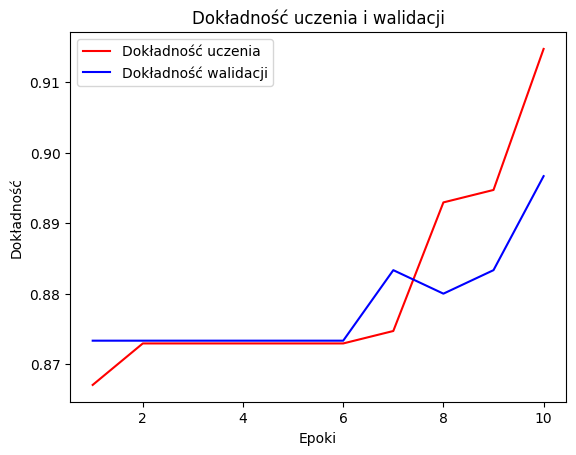

In [ ]:
# Wygenerowanie wykresu dokładności uczenia i walidacji
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, 'r', label='Dokładność uczenia')
plt.plot(epochs, val_accuracy, 'b', label='Dokładność walidacji')
plt.title('Dokładność uczenia i walidacji')
plt.xlabel('Epoki')
plt.ylabel('Dokładność')
plt.legend()
plt.show()


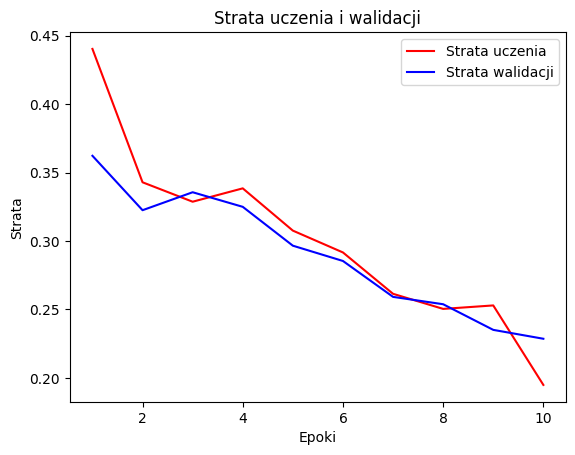

In [ ]:
# Wygenerowanie wykresu straty uczenia
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, 'r', label='Strata uczenia')
plt.plot(epochs, val_loss, 'b', label='Strata walidacji')
plt.title('Strata uczenia i walidacji')
plt.xlabel('Epoki')
plt.ylabel('Strata')
plt.legend()
plt.show()

In [ ]:
# Ocena modelu na zbiorze testowym
test_loss, test_accuracy = model.evaluate(X_test_features, y_test_classes)

print("Strata na zbiorze testowym:", test_loss)
print("Dokładność na zbiorze testowym:", test_accuracy)

16/16 [==============================] - 12s 723ms/step - loss: 0.7931 - accuracy: 0.1277
Strata na zbiorze testowym: 0.7930895090103149
Dokładność na zbiorze testowym: 0.12774451076984406


In [ ]:
y_pred = model.predict(X_test_features)

16/16 [==============================] - 11s 676ms/step


In [ ]:
from sklearn.metrics import classification_report
threshold = 0.5  # próg decyzyjny

# Przekształcenie wartości ciągłych na wartości binarne
y_pred_binary = np.where(y_pred >= threshold, 1, 0)
y_test_binary = np.where(y_test_classes >= threshold, 1, 0)

# Ocena modelu
report = classification_report(y_test_binary, y_pred_binary)
print(report)


              precision    recall  f1-score   support

           0       0.13      1.00      0.23        64
           1       0.00      0.00      0.00       437

    accuracy                           0.13       501
   macro avg       0.06      0.50      0.11       501
weighted avg       0.02      0.13      0.03       501



/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

16/16 [==============================] - 11s 680ms/step


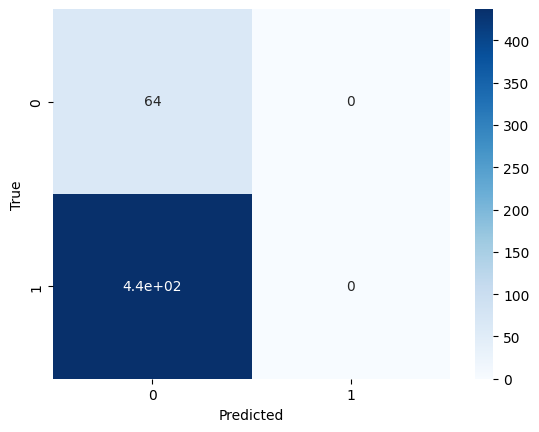

In [ ]:
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test_features)

threshold = 0.5  # próg decyzyjny

# Przekształcenie wartości ciągłych na wartości binarne
y_pred_binary = np.where(y_pred >= threshold, 1, 0)
y_test_binary = np.where(y_test_classes >= threshold, 1, 0)

# Wygenerowanie macierzy pomyłek
cm = confusion_matrix(y_test_binary, y_pred_binary)
sns.heatmap(cm, annot=True, cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


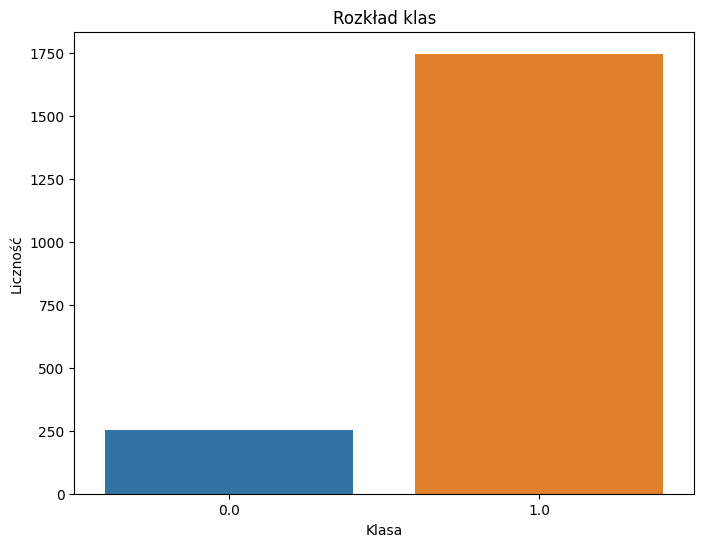

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Analiza rozkładu klas
plt.figure(figsize=(8, 6))
sns.countplot(x=y_train_classes)
plt.xlabel('Klasa')
plt.ylabel('Liczność')
plt.title('Rozkład klas')
plt.show()

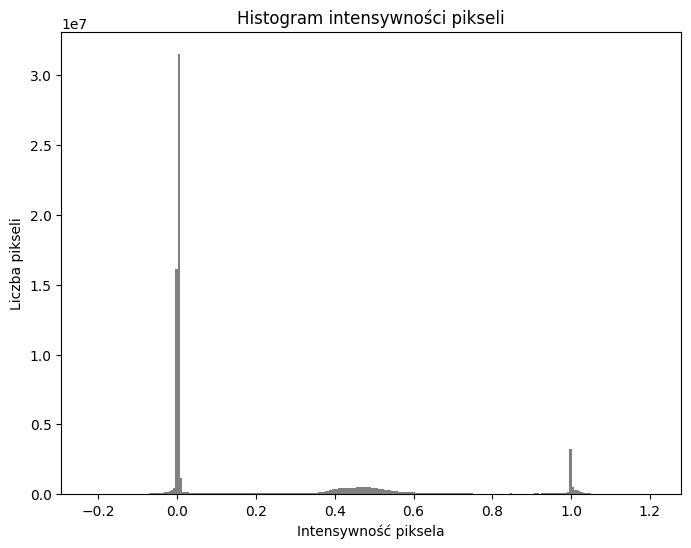

In [ ]:
# Analiza histogramu intensywności pikseli
plt.figure(figsize=(8, 6))
plt.hist(X_train_features.flatten(), bins=256, color='gray')
plt.xlabel('Intensywność piksela')
plt.ylabel('Liczba pikseli')
plt.title('Histogram intensywności pikseli')
plt.show()

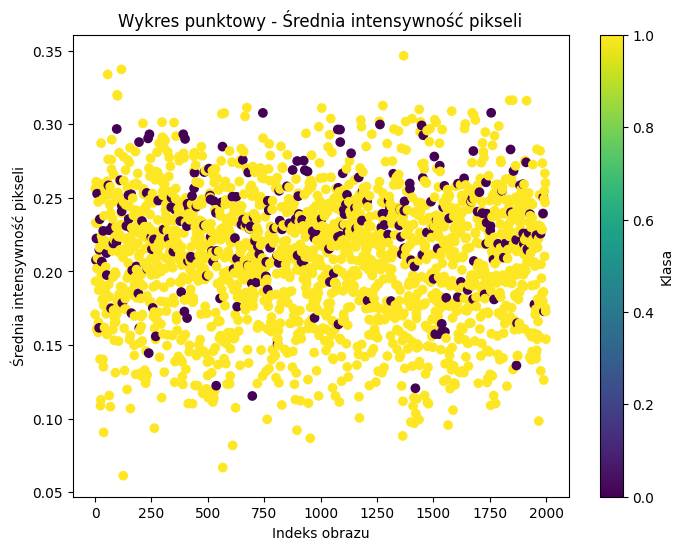

In [ ]:
# Wykres punktowy
plt.figure(figsize=(8, 6))
plt.scatter(range(len(y_train_classes)), X_train_features.mean(axis=(1, 2)), c=y_train_classes, cmap='viridis')
plt.xlabel('Indeks obrazu')
plt.ylabel('Średnia intensywność pikseli')
plt.title('Wykres punktowy - Średnia intensywność pikseli')
plt.colorbar(label='Klasa')
plt.show()